# Setup & Cleaning

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Dataset:
# https://www.kaggle.com/tmdb/tmdb-movie-metadata/downloads/tmdb-5000-movie-dataset.zip/2

from google.colab import files
uploaded = files.upload()

credits = pd.read_csv("tmdb_5000_credits.csv")

Saving tmdb_5000_credits.csv to tmdb_5000_credits.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

movies_incomplete = pd.read_csv("tmdb_5000_movies.csv")

Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv


In [ ]:
# Shapes of dataframes
print("credits:", credits.shape)
print("movies_incomplete:",movies_incomplete.shape)

credits: (4803, 4)
movies_incomplete: (4803, 20)


In [ ]:
# Credit to Ibtesam Ahmed for her kernel:
# https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

credits_renamed = credits.rename(index=str, columns={"movie_id": "id"})
movies_dirty = movies_incomplete.merge(credits_renamed, on='id')
movies_dirty.head()

In [ ]:
movies_clean = movies_dirty.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries'])
movies_clean.head()

# Basic Recommender Systems

In [ ]:
V = movies_clean['vote_count']
R = movies_clean['vote_average']
C = movies_clean['vote_average'].mean()
m = movies_clean['vote_count'].quantile(0.70)

movies_clean['weighted_average'] = (V/(V+m) * R) + (m/(m+V) * C)

In [ ]:
movies_ranked = movies_clean.sort_values('weighted_average', ascending=False)
movies_ranked[['original_title', 'vote_count', 'vote_average', 'weighted_average', 'popularity']].head(20)

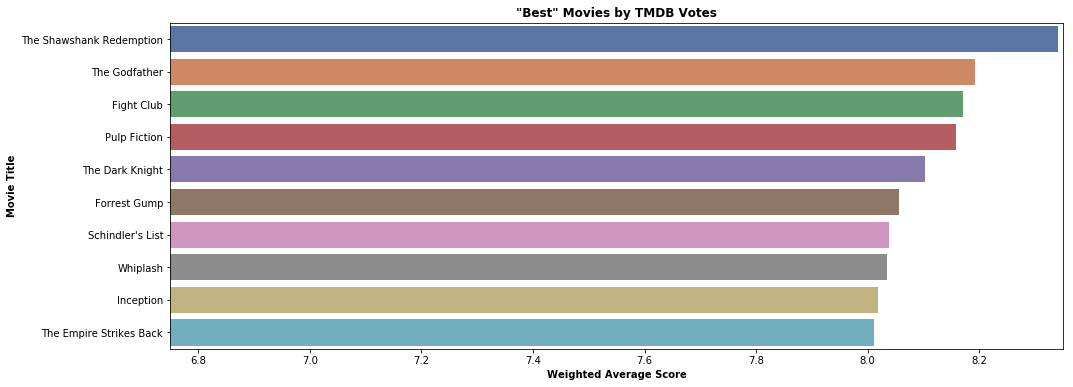

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

wavg = movies_ranked.sort_values('weighted_average', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=wavg['weighted_average'].head(10), y=wavg['original_title'].head(10), data=wavg, palette='deep')

plt.xlim(6.75, 8.35)
plt.title('"Best" Movies by TMDB Votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('best_movies.png')

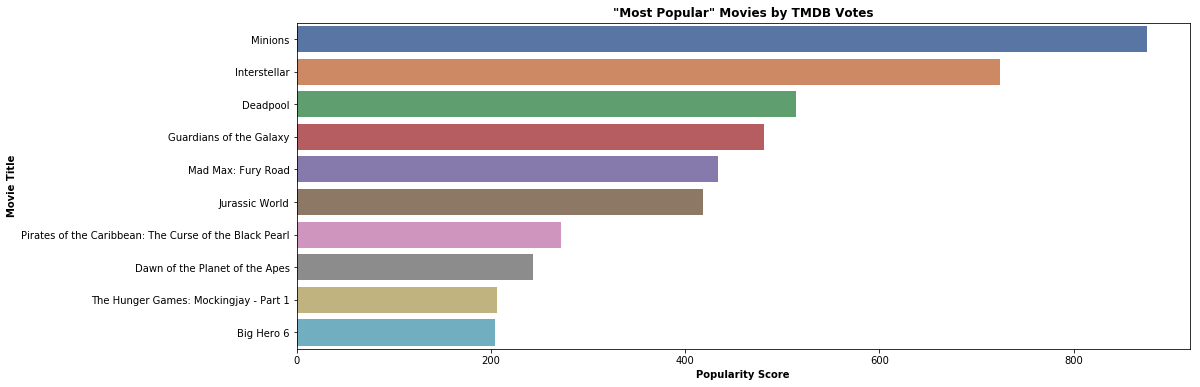

In [ ]:
popular = movies_ranked.sort_values('popularity', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=popular['popularity'].head(10), y=popular['original_title'].head(10), data=popular, palette='deep')

plt.title('"Most Popular" Movies by TMDB Votes', weight='bold')
plt.xlabel('Popularity Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('popular_movies.png')

In [ ]:
# My own recommender system
# half/half recommendation based on scaled weighted average & popularity score

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
movies_scaled = min_max_scaler.fit_transform(movies_clean[['weighted_average', 'popularity']])
movies_norm = pd.DataFrame(movies_scaled, columns=['weighted_average', 'popularity'])
movies_norm.head()

In [ ]:
movies_clean[['norm_weighted_average', 'norm_popularity']] = movies_norm

In [ ]:
movies_clean['score'] = movies_clean['norm_weighted_average'] * 0.5 + movies_clean['norm_popularity'] * 0.5
movies_scored = movies_clean.sort_values(['score'], ascending=False)
movies_scored[['original_title', 'norm_weighted_average', 'norm_popularity', 'score']].head(20)

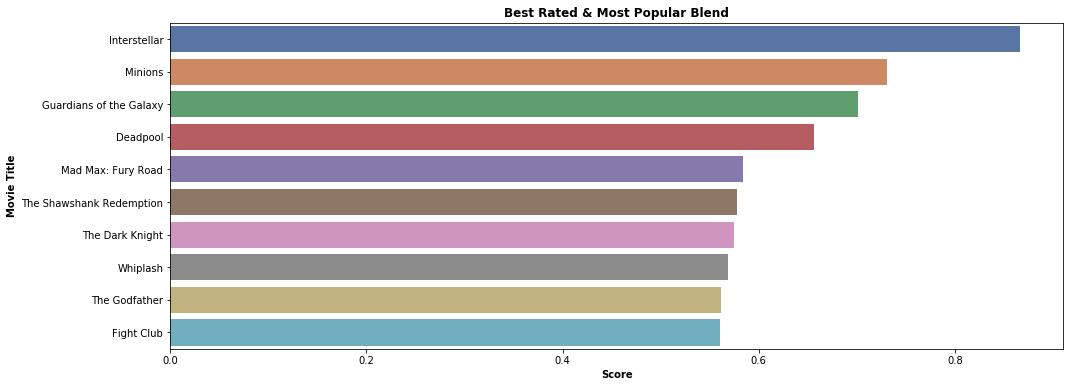

In [ ]:
scored = movies_clean.sort_values('score', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=scored['score'].head(10), y=scored['original_title'].head(10), data=scored, palette='deep')

#plt.xlim(3.55, 5.25)
plt.title('Best Rated & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('scored_movies.png')

# Content-Based Filtering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using Abhishek Thakur's arguments for TF-IDF
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Filling NaNs with empty string
movies_clean['overview'] = movies_clean['overview'].fillna('')

# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(movies_clean['overview'])

tfv_matrix.shape

(4803, 10417)

In [ ]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

# Reverse mapping of indices and movie titles
indices = pd.Series(movies_clean.index, index=movies_clean['original_title']).drop_duplicates()

In [ ]:
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return movies_clean['original_title'].iloc[movie_indices]

In [ ]:
# Testing our content-based recommendation system with the seminal film Spy Kids
give_rec('Spy Kids')

1302    Spy Kids 2: The Island of Lost Dreams
1155                  Spy Kids 3-D: Game Over
1769      Spy Kids: All the Time in the World
3359                              In Too Deep
1631                                 Mr. 3000
4044                               Go for It!
339                           The Incredibles
1081                       Revolutionary Road
1825                Jimmy Neutron: Boy Genius
2441                   Escobar: Paradise Lost
Name: original_title, dtype: object